In [1]:
# Impport of packages
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
import os
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Path to the dataset
train_data_dir   = 'data/train/'
validation_data_dir    = 'data/val/'
test_data_dir = 'data/test/'

In [3]:
# Count plant disease
def count_disease(path, set_name):
    set_dict = {}
    for disease in os.listdir(path):
        set_dict[disease] = len(os.listdir(path + disease))
    df = pd.DataFrame(set_dict, index=[set_name])
    return df

In [4]:
# Count images by disease category
train_count = count_disease(train_data_dir, 'trainset')
test_count  = count_disease(test_data_dir, 'testset')

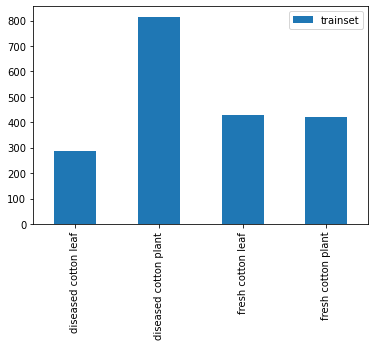

In [5]:
# Plotting training data histogram
train_count.transpose().plot(kind = 'bar')

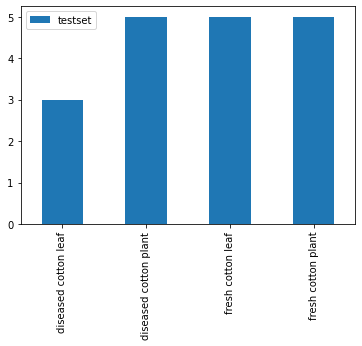

In [6]:
# Plotting testing data histogram
test_count.transpose().plot(kind = 'bar')

In [7]:
# For each class plot some images (4 per class here)
def plot_img(item_dir, top = 10):
    for dir_name in os.listdir(item_dir):
        item_files    = [os.path.join(item_dir+dir_name+'/', file) for file in os.listdir(item_dir+dir_name)][:4]
        plt.figure(figsize = (10, 10))
        for idx, img_path in enumerate(item_files):
            plt.subplot(5, 5, idx + 1)
            img = plt.imread(img_path)
            plt.title(dir_name)
            plt.tight_layout()         
            plt.imshow(img)

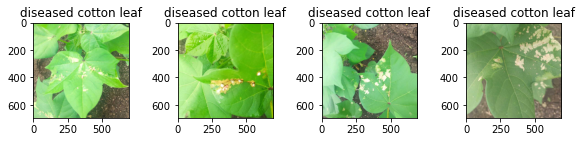

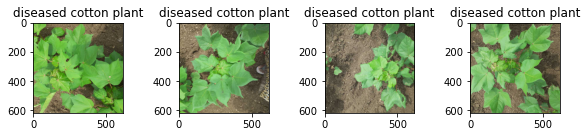

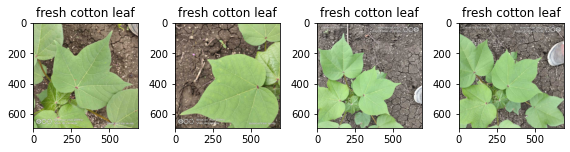

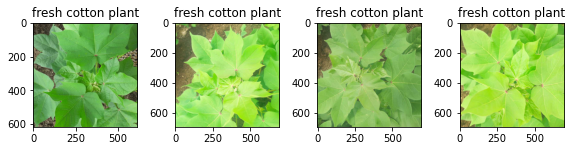

In [8]:
plot_img(train_data_dir)

In [9]:
class PlantDiseasePredictor:
    def build_model(width, height, depth, classes):
        model = Sequential()
        input_shape = (height, width, depth)
        model.add(Conv2D(filters=32, kernel_size=3, input_shape=input_shape, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(filters=128, kernel_size=3))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.5))
        
        model.add(Flatten())
        model.add(Dense(units=128, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(units=256, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(units=classes, activation='softmax'))
        
        return model

In [10]:
# Train data genarator 
train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

train_data = train_datagen.flow_from_directory(train_data_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=32,
                                                  class_mode = 'categorical',
                                                  shuffle = True)  

Found 1951 images belonging to 4 classes.


In [11]:
train_data.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [12]:
# Validation data generator
test_datagen = ImageDataGenerator(rescale=1./255)

validation_data = test_datagen.flow_from_directory(validation_data_dir,
                                             target_size=(150,150),
                                             batch_size=32,
                                             class_mode='categorical',
                                             shuffle = True)

test_data = test_datagen.flow_from_directory(test_data_dir,
                                             target_size=(150,150),
                                             batch_size=32,
                                             class_mode='categorical',
                                             shuffle = True)

Found 324 images belonging to 4 classes.
Found 18 images belonging to 4 classes.


In [13]:
checkpoint = ModelCheckpoint('./output/plant_disease_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [PlotLossesKeras(), checkpoint]

In [14]:
# Compile the model
model = PlantDiseasePredictor.build_model(150, 150, 3, 4)
model.compile(optimizer = Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
 

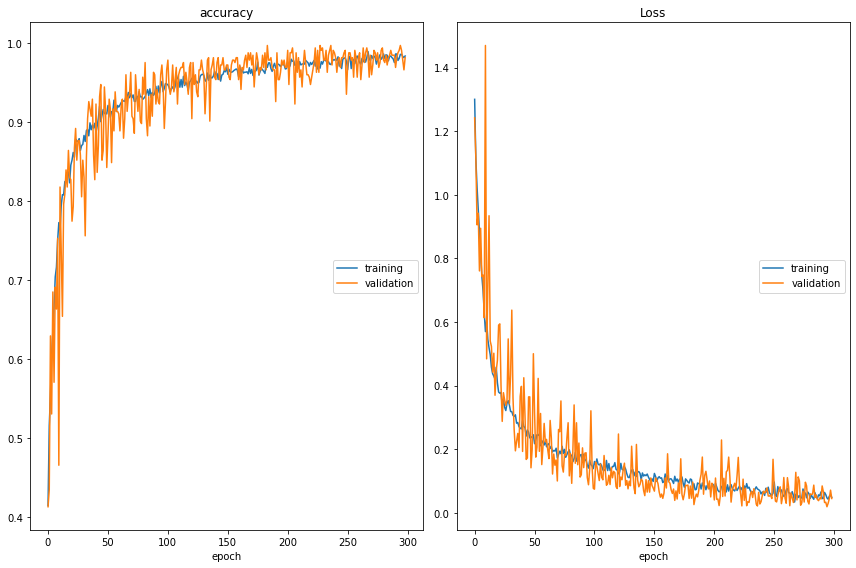

accuracy
	training         	 (min:    0.415, max:    0.989, cur:    0.984)
	validation       	 (min:    0.414, max:    0.997, cur:    0.981)
Loss
	training         	 (min:    0.034, max:    1.300, cur:    0.049)
	validation       	 (min:    0.019, max:    1.470, cur:    0.045)

Epoch 00299: val_accuracy did not improve from 0.99691
61/61 [==============================] - 61s 994ms/step - loss: 0.0488 - accuracy: 0.9836 - val_loss: 0.0451 - val_accuracy: 0.9815
Epoch 300/300
56/61 [==========================>...] - ETA: 4s - loss: 0.0432 - accuracy: 0.9872

In [ ]:
# train the cnn model
history =model.fit(train_data, 
                          epochs=300, 
                          verbose=1, 
                          validation_data= validation_data,
                          callbacks=callbacks_list)

In [ ]:
# evaluate the model  on test data
_, acc = model.evaluate(test_data, steps=len(test_data), verbose=0)
print('> %.3f' % (acc * 100.0))